# Baseline performance
In this notebook, I analyze the performance for the baseline HGS-VRPTW implementation. See [Issue #19](https://github.com/N-Wouda/Euro-NeurIPS-2022/issues/19) for the raw data.

The `baseline` data contains two folders: `20K` and `50K`:
- `20K` contains data for the baseline implementation with `nbIter` set to `20000`. Only one seed is used. Time limit 7200s. No restart.
- `50K` contains data for the baseline implementation with `nbIter` set to `50000`. Five different seeds are used, one subdir for each seed. Time limit 7200s. No restart.

For each solved instance, there are three results files:
   - `<inst>.txt`contains the final solution
   - `<inst>.txt.PG.csv` contains the search progress for the incumbent solutions
   - `<inst>.search.log` contains the entire search progress per 500 iterations

where `<inst>` denotes the instance name. Note that we skip instance `ORTEC-VRPTW-ASYM-2e2ef021-d1-n210-k17.txt` in our analysis because the instance is infeasible.

All experiments are run on a Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz, which is currently suggested as the CPU that will be used to evaluate our submission.

To replicate this notebook, unzip the `baseline.zip` data in `data/raw/`.


In [1]:
from pathlib import Path
import os
import re

import numpy as np
import matplotlib.pyplot as plt

In [2]:
k20 = Path('../data/raw/baseline/20K/')
k50 = Path('../data/raw/baseline/50K/')

## Parsing functions

In [3]:
def readlines(path):
    with open(path, 'r') as fi:
        return fi.readlines()
    
def parse_solution(path):
    solution = []
    data = {}
    
    for line in readlines(path):
        if "Route" in line:
            route = [int(cust) for cust in re.match(r"Route #\d+: (.*)", line).group(1).split()]
            solution.append(route)

        else:
            key, val = line.split()
            data[key] = float(val)                

    return solution, data

    
def parse_pg(path):
    times, costs = [], []
    
    for line in readlines(path):
        inst_path, seed, cost, time = line.strip().split(';')
        times.append(float(time))
        costs.append(int(cost))
        
    return np.array(times), np.array(costs)
    
def parse_search(path):
    parse = 0
    iters, times, costs = [], [], []

    for line in readlines(path):
        if line.startswith("----- STARTING"):
            parse = 1

        elif line.startswith("----- GENETIC ALGORITHM FINISHED"):
            parse = 0

        elif parse:
            data = [section.split() for section in line.split(" | ")][:3]
            data = {section[0]: section[1:] for section in data}

            iters.append(int(data["It"][0]))
            times.append(float(data["T(s)"][0]))
            
            if "Feas" in data:
                costs.append(float(data["Feas"][1]))
            else:
                costs.append(np.nan)
    
    return {'iters': np.array(iters), 'times': np.array(times), 'costs': np.array(costs)}

In [4]:
def instances():
    """Return instance names and ignore the infeasible inst."""
    ignore = ['ORTEC-VRPTW-ASYM-2e2ef021-d1-n210-k17.txt']
    inst_dir = Path('../instances')
    return [name for name in os.listdir(inst_dir) if name not in ignore]

def inst_size(name):
    return int(name.split('-n')[1][:3])

def append(path, postfix):
    return path.with_name(f'{path.name}{postfix}')

def add(a, b):
    """Add two arrays with different sizes element-wise from left to right."""
    if len(a) < len(b):
        c = b.copy()
        c[:len(a)] += a
    else:
        c = a.copy()
        c[:len(b)] += b
    return c

# Average costs
We first compute the average costs over all instances for 20K and the results from 50K & all seeds.

In [5]:
costs = []

for inst in instances():
    sol, extra = parse_solution(k20 / inst)
    costs.append(extra['Cost'])

avg_20k = np.mean(costs)
print(f"Avg. cost (20K): {avg_20k:.2f}")

Avg. cost (20K): 164359.47


In [6]:
avg_all_seeds = []

for seed in range(5):
    costs = []

    for inst in instances():
        sol, data = parse_solution(k50 / str(seed) / inst)
        costs.append(data['Cost'])

    avg_cost = np.mean(costs)
    avg_all_seeds.append(avg_cost)
    print(f"Avg. cost (50K, {seed=}):    {avg_cost:.2f}")
    
avg_50k = np.mean(avg_all_seeds)
print(f"Avg. cost (50K, all seeds): {avg_50k:.2f}\n")

print(f"Improvement over 20K: {(avg_20k-avg_50k)/avg_50k * 100:.2f}%")

Avg. cost (50K, seed=0):    164274.51
Avg. cost (50K, seed=1):    164217.97
Avg. cost (50K, seed=2):    164272.29
Avg. cost (50K, seed=3):    164254.05
Avg. cost (50K, seed=4):    164280.07
Avg. cost (50K, all seeds): 164259.78

Improvement over 20K: 0.06%


Increasing the number of non-improving iterations from 20K to 50K did not help that much. FYI: In the report by Kool et al., they use 10K for non-improving iterations and reset the population until the time limit is reached. 

In the remaining part of the notebook, I'll only focus on the results from 50K.

# Best solutions
Although the averages do not differ per seed, we now look at the best solutions for each instance over all seeds. We do not look at the 20K results, because I checked that they are not worse than the 50K with seed 0 results.

In [7]:
bks = []

for inst in instances():
    best_cost, best_sol = None, None
    
    for seed in range(5):
        sol, data = parse_solution(k50 / str(seed) / inst)
        cost = data['Cost']
        
        if best_cost is None or cost < best_cost:
            best_cost = cost
            best_sol = sol
    
    bks.append([inst, int(best_cost), sol])

In [8]:
avg_bks = np.mean([cost for (_, cost, _) in bks])
print(f"Avg. cost (50K, best seed):   {avg_bks:.2f}")
print(f"Improvement over average 50K: {(avg_50k-avg_bks)/avg_bks * 100:.2f}%")

Avg. cost (50K, best seed):   163961.41
Improvement over average 50K: 0.18%


There is a slight improvement if we store the best solutions for each instance over all seeds. We save these as the best known solutions for future comparisons:

In [9]:
with open('../data/out/best_known_solutions.csv', 'w') as fi:
    for (inst, cost, sol) in bks:
        fi.write(inst)
        fi.write(';')
        fi.write(str(cost))
        fi.write(';')
        fi.write(str(sol))
        fi.write('\n')

# Solution quality vs. running time
We now move on to analyze how "fast" the initial solutions converges to the best solution. We use the results from 50K and seed 0.

We normalize the initial objective to 1 and the best objective to 0. We then plot the normalized incumbent solutions against running time.

In [10]:
def compute_normalized_costs(path):
    data = parse_search(path)
    iters, times, _costs = data['iters'], data['times'], data['costs']
    
    # Infeasible solutions have NaN cost; replace with first feasible cost
    costs = np.nan_to_num(_costs, nan=np.nanmax(_costs))
    
    max_gap = costs[0] - costs[-1]
    normalized_costs = (costs - costs[-1]) / max_gap
    
    return iters, times, normalized_costs

## All instances

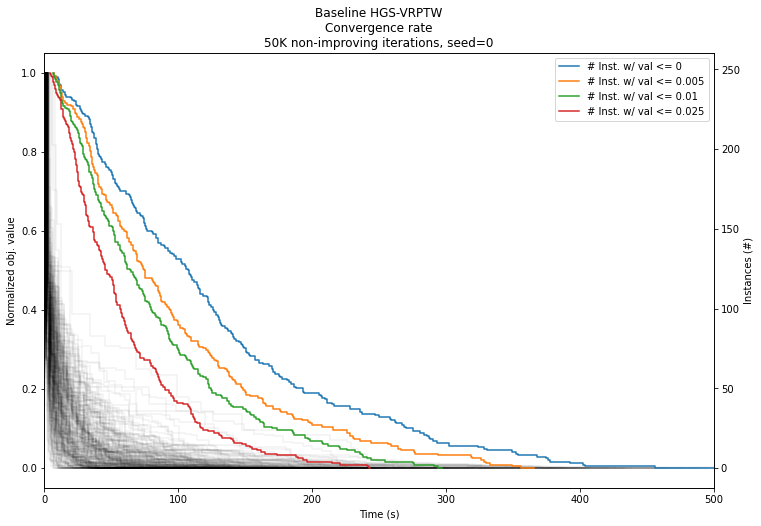

In [11]:
def plot_runtime():
    fig, ax1 = plt.subplots(figsize=[12, 8])
    ax2 = ax1.twinx()
    ax2.set_ylabel('Instances (#)')
    avg_norm_costs = np.zeros(1)

    threshold_vals = [0, 0.005, 0.01, 0.025]
    final = {gap: [] for gap in threshold_vals}

    for inst in instances():
        path = append(k20 / inst, '.search.log')
        iters, times, normalized_costs = compute_normalized_costs(path)
        
        for gap in threshold_vals:
            first_hit = np.argmax(normalized_costs <= gap)
            final[gap].append(times[first_hit])

        ax1.step(times, normalized_costs, alpha=0.05, color='black')
        ax1.set_xlim(0, 500)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Normalized obj. value')

    for gap in threshold_vals:
        n_instances = np.arange(len(instances()) - 1, -1, -1)
        ax2.step(sorted(final[gap]), n_instances, label=f"# Inst. w/ val <= {gap}")

    plt.title('Baseline HGS-VRPTW\nConvergence rate\n50K non-improving iterations, seed=0')

    ax2.legend()
    
plot_runtime()

The black lines show the normalized objective values over time for each instance run. The colored lines show the number of instances that have normalized objective value below a certain value. As can be seen from the blue line, almost all solutions have converged to the best solution by time 450. 

## Per time limit group
Rather than analyzing all instances at once, we also plot the trajectories per time limit group, which is based on the instance size:
- `n < 300`: 3 and 5 min
- `300 <= n <= 500`: 5 and 10 min
- `n > 500`: 8 and 15 min

Time limits are for the qualification and test phase, respectively.

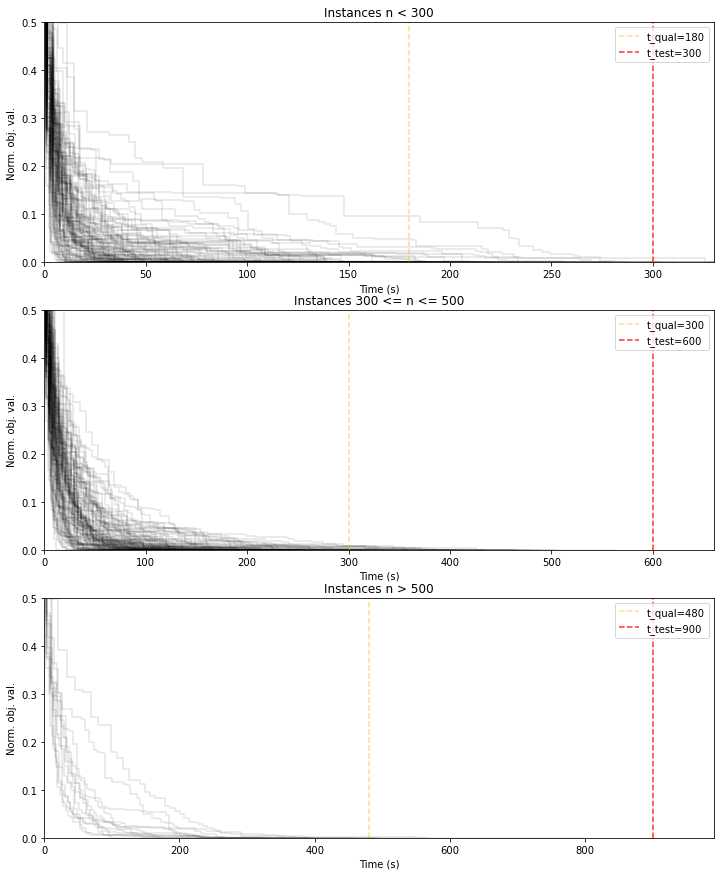

In [12]:
def group_num(n):
    if n < 300:
        return 0
    if 300 <= n <= 500:
        return 1
    if n > 500:
        return 2

def plot_per_time_limit_group():
    fig, axes = plt.subplots(3, 1, figsize=[12, 15])
    group_names = {0: "n < 300", 1: "300 <= n <= 500", 2: "n > 500"}

    def subplot(group, t_qual, t_test):
        for inst in instances():
            if group_num(inst_size(inst)) == group:
                path = append(k20 / inst, '.search.log')
                iters, times, normalized_costs = compute_normalized_costs(path)
                axes[group].step(times, normalized_costs, alpha=0.10, color='black')

        # Plot vertical time limit lines
        axes[group].vlines(t_qual, ymin=0, ymax=1, color='orange', alpha=0.4, linestyles='dashed', label=f'{t_qual=}')
        axes[group].vlines(t_test, ymin=0, ymax=1, color='red', alpha=0.8, linestyles='dashed', label=f'{t_test=}')

        axes[group].set_ylim(0, 0.5)
        axes[group].set_xlim(0, t_test * 1.1)
        axes[group].set_xlabel('Time (s)')
        axes[group].set_ylabel('Norm. obj. val.')
        axes[group].set_title(f"Instances {group_names[group]}")
        axes[group].legend()

    subplot(0, 180, 300)
    subplot(1, 300, 600)
    subplot(2, 480, 900)
    
plot_per_time_limit_group()